Akhil's Feature Engineering File

labels:
    fall = 1
    impact = 2
    nothing = 3
    squeeze = 4

In [13]:
# Import packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal
from copy import copy, deepcopy

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 


In [14]:
#This block imports all fall, impact, nothing, and squeeze data and formats 
    #it into a 56x1001x16 data matrix. Also creates a 56 length label array. 
#Each 1001x16 matrix contains the data from one test 
#The 16 columns are time (in seconds), FSR1, FSR2, FSR3, FSR4, FSR5, FSR6, FSR7, 
#    FSR8, FSR9, FSR10, FSR11, FSR12, acc_x, acc_y, acc_z. There are 1001 data points. 
#Note:
    #The FSR data is raw data and has not been converted to Newtons
    #The time data was converted to seconds 

#falldata
string = "/Users/akhil/Documents/BEST/AkhilProcessingData/fall"
numbers = np.arange(1,15) 
data = []
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    d = d.drop(columns = ["IND"])
    d = d.to_numpy()
    data.append(d)
    
#impactdata 
string = "/Users/akhil/Documents/BEST/AkhilProcessingData/impact"
numbers = np.arange(1,15)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])

    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    d = d.drop(columns = ["IND"])
    d = d.to_numpy()
    data.append(d)
    
#nothingdata 
string = "/Users/akhil/Documents/BEST/AkhilProcessingData/nothing"
numbers = np.arange(1,15)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
 
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    d = d.drop(columns = ["IND"])
    d = d.to_numpy()
    data.append(d)
    
    
#squeezedata 
string = "/Users/akhil/Documents/BEST/AkhilProcessingData/squeeze"
numbers = np.arange(1,15)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    d = d.drop(columns = ["IND"])
    d = d.to_numpy()
    data.append(d)
    
#create label array
l1 = np.ones((14,), dtype=int) 
l2 = 2*np.ones((14,), dtype=int) 
l3 =  3*np.ones((14,), dtype=int)
l4 =  4*np.ones((14,), dtype=int)
labels = np.concatenate((l1, l2, l3, l4), axis=0)

print("Matrix Dimensions of data: " + str(np.shape(data)))
print("Matrix Dimensions of labels: " + str(np.shape(labels)))


Matrix Dimensions of data: (56, 1001, 16)
Matrix Dimensions of labels: (56,)


In [15]:
#Force Divider Function
def force_divider(x):
    k_outer = 3.738
    k_inner = 0.368
    dist = x/k_inner
    return (k_outer + k_inner)*dist

#FSR model function
def FSR_model(x):
    return 131.2*np.exp(0.7801*x)/1000

#this code converts all raw fsr data in the data matrix to Newtons 
for m in data:
    m[:,1:13] = force_divider(FSR_model(m[:,1:13] *5/1023))  

#d = pd.DataFrame(data[1])
#d.head()

In [16]:
#feature function block 
def impulse(data_matrix):
    #total impulse function for a single matrix of data 
    #iterates over data and computes the total impulse for all sensors over time 
    fsr_data = data_matrix[:,1:13]
    impulse = 0
    for col in np.arange(1,13):
        single_FSR = data_matrix[:,col]
        time = data_matrix[:,0]
        for i in np.arange(0,len(time)-1):
            delta_t = time[i+1]- time[i]
            averagef = (single_FSR[i+1] + single_FSR[i])/2 
            impulse = impulse + averagef*delta_t
    return impulse 


def jerk(data_matrix): 
    #iterates over data and computes the max jerk for each sensor over time
    #takes the max jerk over all FSR sensors and returns  
    fsr_data = data_matrix[:,1:13]
    jerk_array = []
    for col in np.arange(1,13):
        single_FSR = data_matrix[:,col]
        time = data_matrix[:,0]
        all_jerks = []
        for i in np.arange(0,len(time)-1):
            delta_t = time[i+1] - time[i]
            delta_f = single_FSR[i+1] - single_FSR[i]
            all_jerks.append(delta_f/delta_t)
        jerk_array.append(np.amax(all_jerks))
    max_jerk = np.amax(jerk_array)
    return max_jerk

def max_force(data_matrix):
    #max force readings across all sensors for a single matrix of data 
    fsr_data = data_matrix[:,1:13]
    force_array = [] 
    for col in np.arange(1,13):
        single_FSR = data_matrix[:,col]
        max_force_sensor = np.amax(single_FSR)
        force_array.append(max_force_sensor)
    max_force = np.amax(force_array)
    return max_force

In [1]:
#this block resamples data to smooth out noise 

smooth_data = deepcopy(data)

for m in smooth_data:
    for c in np.arange(1,13):
        m[:,c] = signal.savgol_filter(m[:,c], 71, 3)
        
figure(figsize=(15, 10))
plt.plot(smooth_data[1][:,0], smooth_data[1][:,3])



NameError: name 'deepcopy' is not defined

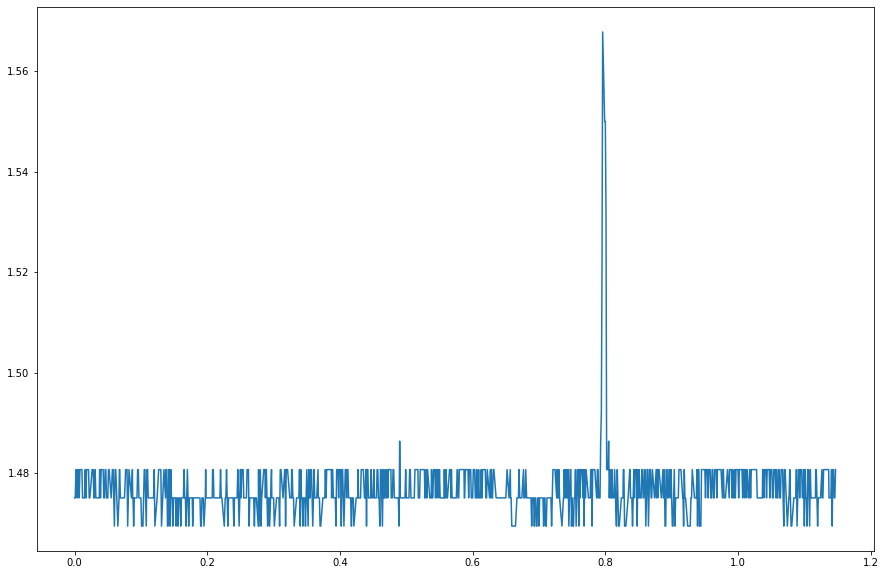

In [18]:
figure(figsize=(15, 10))
plt.plot(data[1][:,0], data[1][:,3])

In [19]:
#Max Force Comparison
print("Fall Values")
for m in smooth_data[0:14]:
    print(max_force(m))

print(" ")
print("Impact Values")
for m in smooth_data[14:28]:
    print(max_force(m))
    
print(" ")
print("Nothing Values")
for m in smooth_data[28:42]:
    print(max_force(m))
    
print(" ")
print("Squeeze Values")
for m in smooth_data[42:57]:
    print(max_force(m))

Fall Values
5.700517716044924
7.155142007320025
7.2496351670592265
6.679478407572737
6.705044053115962
7.66209838299045
6.593065264938326
7.485458346283044
6.99574542925274
7.71277732089347
8.01947863710372
6.463423570733636
6.74148308280984
6.719474324587097
 
Impact Values
14.969329844604292
12.2368952317815
14.738286055270082
10.952509849172428
12.643678893368197
12.630923966565774
17.066881736646863
16.705200476532188
13.276334200173695
10.323708132100416
14.31870242382939
15.889843035733517
10.321459692144138
11.257024488440479
 
Nothing Values
5.499234200927875
7.128235878357762
6.32238666319188
6.66652714238241
7.658253397765324
6.1366478795769535
6.438497793697736
7.332079169935826
6.99830077534342
7.690507730009979
7.163134535321446
6.458222895375993
6.99874589392656
6.637305531041387
 
Squeeze Values
13.732140004517923
14.608394183519426
14.320074932823625
14.85304265587832
16.083983767771393
16.90913180747534
18.142800336555105
13.671643644545878
14.148696035361146
10.677407

In [20]:
#Jerk Comparison
print("Fall Values")
for m in smooth_data[0:14]:
    print(jerk(m))

print(" ")
print("Impact Values")
for m in smooth_data[14:28]:
    print(jerk(m))
    
print(" ")
print("Nothing Values")
for m in smooth_data[28:42]:
    print(jerk(m))
    
print(" ")
print("Squeeze Values")
for m in smooth_data[42:57]:
    print(jerk(m))

Fall Values
12.969982816007311
15.65451375054432
20.0247867000922
35.737946499883385
6.837774883010812
8.308839440844613
28.898983042062838
9.781132918729412
8.727351460604329
10.304656388538461
10.899021698006008
9.549455439664026
5.7720128423794215
14.80305612178047
 
Impact Values
581.829553207266
351.5460829949579
745.5346947411438
439.0074857470308
427.6085606215758
525.4570909663289
754.0341939638447
679.7424753480896
729.5237271601274
462.1624920843198
453.109751569309
503.44419517854357
338.8354878016852
401.3712223073375
 
Nothing Values
11.270755191111967
4.58955858046578
5.548734287714581
4.984047846655234
8.304237566036177
4.39235868298789
7.028491964711884
5.0540013610421255
4.822774578916083
10.90329303115227
9.079052928909496
4.661803891884141
6.012500203077504
5.057039618589834
 
Squeeze Values
74.56778306698966
107.48843784160812
75.84707696022417
353.37963231544245
348.0793214987747
738.7025577917598
669.5688228637091
77.31628504143028
127.53106114704256
71.3304926880

In [21]:
#Impulse Values
print("Fall Values")
for m in smooth_data[0:14]:
    print(impulse(m))

print(" ")
print("Impact Values")
for m in smooth_data[14:28]:
    print(impulse(m))
    
print(" ")
print("Nothing Values")
for m in smooth_data[28:42]:
    print(impulse(m))
    
print(" ")
print("Squeeze Values")
for m in smooth_data[42:57]:
    print(impulse(m))

Fall Values
34.678842305621195
41.081599365310915
39.055761484551475
38.235467095708486
38.95848667908461
40.32350584898645
39.23003228021553
37.01614322668847
36.3835007445828
38.07997766444202
37.72304100813877
38.683087580987
37.81893451878263
37.05810863280548
 
Impact Values
37.976350731742095
39.63484794667595
37.77451033240594
37.52918306031099
36.414953267577914
36.68758609306845
36.35800509736131
37.54471919725042
37.20144636488645
37.60046747970637
38.84112102054183
40.7243179097306
38.75270934281736
39.6341871588958
 
Nothing Values
43.228248233336906
40.19890345899421
38.69290842410699
38.72173698378132
41.07640852730916
36.86882055966274
41.2364421376975
36.66535751824005
37.02946039734011
38.5365216868018
42.845041980271596
37.762909932167524
38.98876332426993
38.1713633469124
 
Squeeze Values
67.59380176957288
76.01886472542715
71.75594079310883
75.38342702094049
81.26514852544716
95.76836350075132
116.05835972211408
59.64428920804249
57.78819750264262
46.17055037617595


In [25]:
feature_data = []
for m in smooth_data:
    maxf = max_force(m)
    j = jerk(m)
    i = impulse(m)
    features = [maxf, j, i]
    feature_data.append(features)
    
np.shape(feature_data)

[X_train, X_test, y_train, y_test] = train_test_split(feature_data, labels, random_state=0)


In [26]:
#Naive Bayes Implementation 
nb = GaussianNB().fit(X_train, y_train)
print(nb.score(X_train, y_train))
print(nb.score(X_test, y_test))
print("Predicted labels = " + str(nb.predict(X_test)))
print("Correct labels =   " + str(y_test))

0.9047619047619048
0.7857142857142857
Predicted labels = [4 3 3 2 3 1 3 4 4 3 3 1 1 2]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


In [27]:
#Random Forest Implementation 
rf = RandomForestClassifier().fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))
print("Predicted labels = " + str(rf.predict(X_test)))
print("Correct labels =   " + str(y_test))

1.0
0.8571428571428571
Predicted labels = [4 3 3 2 3 1 1 4 4 3 1 1 3 2]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


In [28]:
#using just nothing, impact, and squeeze data
cropped_data = smooth_data[14:57]
cropped_labels = labels[14:57]

feature_data = []
for m in cropped_data:
    maxf = max_force(m)
    j = jerk(m)
    i = impulse(m)
    features = [maxf, j, i]
    feature_data.append(features)
    
print(np.shape(feature_data))
print(" ")

[X_train, X_test, y_train, y_test] = train_test_split(feature_data, cropped_labels, random_state=0)


#Naive Bayes Implementation 
nb = GaussianNB().fit(X_train, y_train)
print(nb.score(X_train, y_train))
print(nb.score(X_test, y_test))
print("Predicted labels = " + str(nb.predict(X_test)))
print("Correct labels =   " + str(y_test))

print(" ")
#Random Forest Implementation 
rf = RandomForestClassifier().fit(X_train, y_train)
print(nb.score(X_train, y_train))
print(nb.score(X_test, y_test))
print("Predicted labels = " + str(rf.predict(X_test)))
print("Correct labels =   " + str(y_test))

(42, 3)
 
1.0
1.0
Predicted labels = [4 4 3 2 2 3 4 2 4 4 4]
Correct labels =   [4 4 3 2 2 3 4 2 4 4 4]
 
1.0
1.0
Predicted labels = [4 4 3 2 2 3 4 2 4 4 4]
Correct labels =   [4 4 3 2 2 3 4 2 4 4 4]
